In [34]:
# NAME-RANJAN KUMAR
# ROLL-22103049
# KAGGLE ID-Ranjan9779


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define train and test data directories
train_dir = "/content/drive/MyDrive/crack-detection-image-classification-2023/train"
test_dir = "/content/drive/MyDrive/crack-detection-image-classification-2023/test"

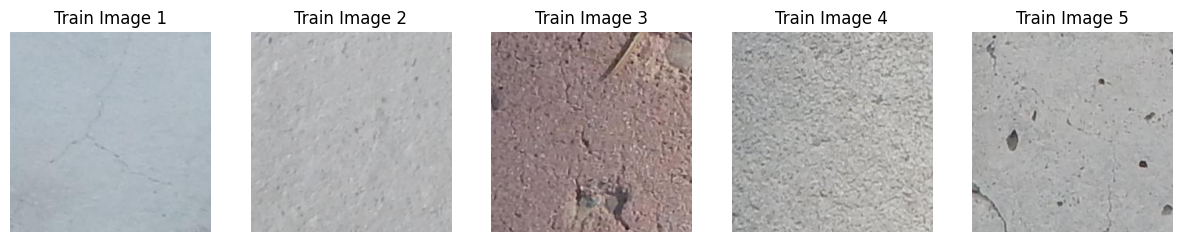

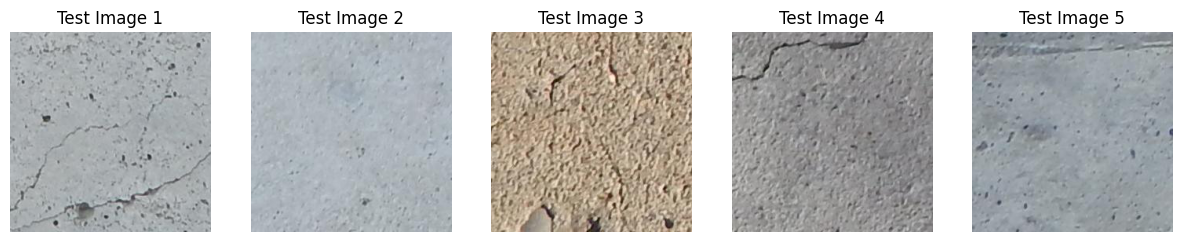

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tensorflow.keras.preprocessing import image

# Set the path to the train and test folders
train_folder = train_dir
test_folder = test_dir

# Get a list of all the image files in the train folder
train_files = []
for subdir in os.listdir(train_folder):
    subdir_path = os.path.join(train_folder, subdir)
    if os.path.isdir(subdir_path):
        train_files.extend([os.path.join(subdir_path, f) for f in os.listdir(subdir_path) if f.endswith('.jpg')])

# Get a list of all the image files in the test folder
test_files = [os.path.join(test_folder, f) for f in os.listdir(test_folder) if f.endswith('.jpg')]

# Choose 5 random images from the train set and 5 random images from the test set
random.shuffle(train_files)
random.shuffle(test_files)
train_img_paths = train_files[:10]
test_img_paths = test_files[:10]

# Load and plot the images from the train set
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes.flat):
    img_path = train_img_paths[i]
    img = image.load_img(img_path)
    img_array = image.img_to_array(img)
    ax.imshow(np.uint8(img_array))
    ax.axis('off')
    ax.set_title('Train Image {}'.format(i+1))
plt.show()

# Load and plot the images from the test set
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes.flat):
    img_path = test_img_paths[i]
    img = image.load_img(img_path)
    img_array = image.img_to_array(img)
    ax.imshow(np.uint8(img_array))
    ax.axis('off')
    ax.set_title('Test Image {}'.format(i+1))
plt.show()


In [2]:
#install Kaggle
!pip install -q kaggle

In [ ]:
#linking google drive for kaggle.json file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# creating creates a new directory named .kaggle.
! mkdir ~/.kaggle

#copies the Kaggle API credentials from the Google Drive to the newly created .kaggle directory.
!cp /content/drive/MyDrive/Colab_Notebooks/Kaggle_Credential/kaggle.json ~/.kaggle/

#command changes the permission of the copied Kaggle API credential file read and write the file
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
#command to downloads the dataset of the competition "crack-detection-image-classification-2023" from Kaggle.
! kaggle competitions download -q -c crack-detection-image-classification-2023 

#command unzips the downloaded dataset.
! unzip -q crack-detection-image-classification-2023.zip 

In [5]:
# Spliting train files into training data and validation data
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import splitfolders
import_fol = '/content/train'
splitfolders.ratio(import_fol, output='dataset', seed = 42, ratio = (.8, .2), group_prefix = None)

Copying files: 14968 files [00:02, 6618.38 files/s]


In [ ]:
!pip install tensorflow

In [8]:
import tensorflow as tf
import os
import cv2
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Set the input image size
IMAGE_SIZE = [256, 256]

# Set the paths to the training and validation data
train_path = '/content/dataset/train'
val_path = '/content/dataset/val'

# Load the Xception pre-trained model
base_model = Xception(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Freeze the layers in the base model except for the last 30 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Add your own layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
prediction = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=prediction)

# Use the ImageDataGenerator to preprocess the data and generate more data with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='binary'
)

# Add early stopping and learning rate reduction callbacks
earlystop_callback = EarlyStopping(monitor='val_loss', patience=5)
lr_reduce_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

# Compile the model with binary crossentropy loss and Adam optimizer with smaller learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model with early stopping and learning rate reduction
r = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=15,
    callbacks=[earlystop_callback, lr_reduce_callback]
)

83683744/83683744 [==============================] - 1s 0us/step
Found 11973 images belonging to 2 classes.
Found 2995 images belonging to 2 classes.
Epoch 1/15
375/375 [==============================] - 246s 598ms/step - loss: 11.1871 - accuracy: 0.6308 - val_loss: 9.8595 - val_accuracy: 0.7352 - lr: 1.0000e-04
Epoch 2/15
375/375 [==============================] - 226s 604ms/step - loss: 8.9822 - accuracy: 0.7048 - val_loss: 7.8314 - val_accuracy: 0.8020 - lr: 1.0000e-04
Epoch 3/15
375/375 [==============================] - 220s 587ms/step - loss: 7.1202 - accuracy: 0.7364 - val_loss: 6.1342 - val_accuracy: 0.8167 - lr: 1.0000e-04
Epoch 4/15
375/375 [==============================] - 221s 588ms/step - loss: 5.5233 - accuracy: 0.7560 - val_loss: 4.7045 - val_accuracy: 0.8150 - lr: 1.0000e-04
Epoch 5/15
375/375 [==============================] - 219s 585ms/step - loss: 4.1984 - accuracy: 0.7676 - val_loss: 3.6023 - val_accuracy: 0.7970 - lr: 1.0000e-04
Epoch 6/15
375/375 [==============

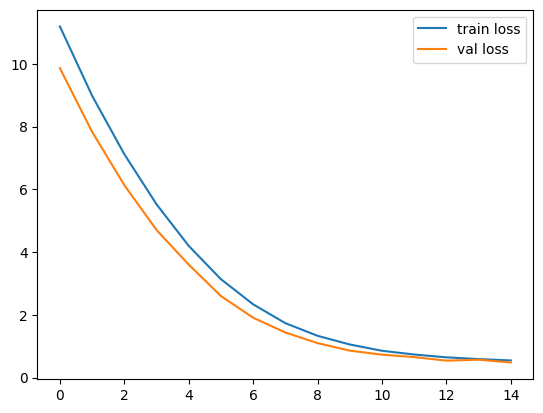

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')



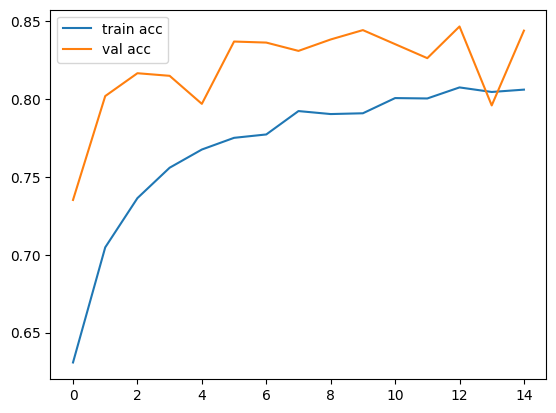

<Figure size 640x480 with 0 Axes>

In [10]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [11]:
# save it as a h5 file
from tensorflow.keras.models import load_model
model.save('model_inception.h5')

In [12]:
# load model
new_model = load_model('model_inception.h5')

In [13]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [14]:
import tensorflow as tf
import numpy as np
import os
import csv

# Define the paths to the test dataset and the saved model
test_dir = '/content/test'

# Load the Xception pre-trained model
base_model = tf.keras.applications.Xception(input_shape=(256, 256, 3), weights='imagenet', include_top=False)

# Define a function to preprocess each image in the test dataset
def preprocess_image(image_path):
    # Load the image and resize it to the input size of the model
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
    # Convert the image to a numpy array
    x = tf.keras.preprocessing.image.img_to_array(img)
    # Reshape the image data to match the expected input shape of the model
    x = tf.keras.applications.xception.preprocess_input(x)
    # Return the preprocessed image
    return x

# Define a list to store the predicted classes
predictions = []

# Define a list to store the true labels and predicted probabilities
true_labels = []
predicted_probabilities = []

# Loop through each image in the test dataset
for i in range(1, 2001):
    # Preprocess the image
    image_path = os.path.join(test_dir, str(i) + '.jpg')
    preprocessed_image = preprocess_image(image_path)
    # Reshape the image data to match the expected input shape of the model
    input_image = np.expand_dims(preprocessed_image, axis=0)
    # Generate the predicted class probabilities for the image
    predictions_for_image = new_model.predict(input_image)
    
    # Append the true label and predicted probability to their respective lists
    true_labels.append(1)  # Change this to 0 or 1 depending on your class labels
    predicted_probabilities.append(predictions_for_image[0][0])

    # Determine the predicted class based on the class probabilities
    predicted_class = 'cracked' if predictions_for_image[0][0] < 0.5 else 'uncracked'
    # Add the predicted class and filename to the list of predictions
    predictions.append((str(i) + '.jpg', predicted_class))

# Save the predicted classes to a CSV file
with open('predictions_new.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['filename', 'class'])
    for p in predictions:
        writer.writerow(p)

1/1 [==============================] - 0s 32ms/step


In [28]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Convert the true labels and predicted probabilities to numpy arrays
true_labels = np.array(true_labels)
predicted_probabilities = np.array(predicted_probabilities)

# Compute the predicted labels using a threshold of 0.3
predicted_labels = (predicted_probabilities > 0.5).astype(int)

# Compute the F1 score, precision, and recall
f1 = f1_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)

# Print the results
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)


F1 score: 0.7017202207075625
Precision: 1.0
Recall: 0.5405


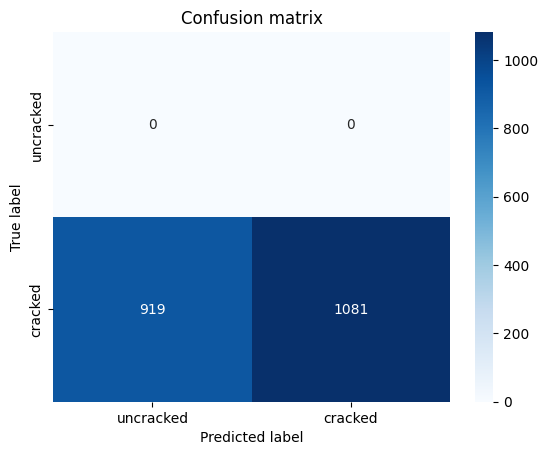

In [29]:
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define the labels for the plot
labels = ['uncracked', 'cracked']

# Plot the heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Set the plot title and axis labels
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Show the plot
plt.show()

In [30]:
import pandas as pd

# Read the CSV file
df = pd.read_csv("predictions_new.csv")

# Print the DataFrame
print(df)


      filename      class
0        1.jpg    cracked
1        2.jpg    cracked
2        3.jpg  uncracked
3        4.jpg  uncracked
4        5.jpg    cracked
...        ...        ...
1995  1996.jpg  uncracked
1996  1997.jpg    cracked
1997  1998.jpg    cracked
1998  1999.jpg    cracked
1999  2000.jpg  uncracked

[2000 rows x 2 columns]


In [31]:
! kaggle competitions submit -c crack-detection-image-classification-2023 -f /content/predictions_new.csv -m test_submission_1

100% 36.2k/36.2k [00:01<00:00, 22.7kB/s]
Successfully submitted to Crack Detection: Image Classification 2023